## Importing Data and Setup

In [128]:
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

# Set options here
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', None)
pd.set_option("display.max.columns", None)
pd.set_option("display.precision", 2)
pd.set_option('display.width', 640)
pd.set_option('display.max_rows', 1000)
sns.set_style("whitegrid")

In [129]:
# Read in the data from the csv file
df_t = pd.read_csv('Tournament-Data.csv')

In [130]:
# The Round column has a space at the end of the column name. Rename it here.
df_t = df_t.rename(columns={'ROUND ':'Round'})

# Set the Round column as a categorical field and order them correctly.
df_t['Round'] = df_t['Round'].astype("category")
df_t['Round'] = df_t['Round'].cat.set_categories(['Play-In', 
                                                    'First Round', 
                                                    'Second Round', 
                                                    'Sweet 16', 
                                                    'Elite Eight', 
                                                    'Final Four', 
                                                    'National Championship'], ordered=True)

In [131]:
# Check out the data
df_t.head()

,YEAR,Round,SEED 1,TEAM 1,SCORE 2,SEED 2,TEAM 2,SCORE,Upset,Upset Val,W_Team,W_Seed,L_Seed,W_Score,L_Score,Difference,LowerSeed,HigherSeed
0,1998,First Round,1,Kansas,110,16,Prairie View,52,Not Upset,0,Kansas,1,16,110,52,58,1,16
1,2009,First Round,1,Connecticut,103,16,Chattanooga,47,Not Upset,0,Connecticut,1,16,103,47,56,1,16
2,1986,First Round,2,Syracuse,101,15,Brown,52,Not Upset,0,Syracuse,2,15,101,52,49,2,15
3,2013,First Round,4,Syracuse,81,13,Montana,34,Not Upset,0,Syracuse,4,13,81,34,47,4,13
4,2002,First Round,1,Duke,84,16,Winthrop,37,Not Upset,0,Duke,1,16,84,37,47,1,16


## Number of Matchups between seeds

First, we take a look at the most common matchups between seeds. In this section, we count the number of times each matchup has occurred.<br><br>
To accomplish this, we first need to perform some transformations on the data.

First we need to count the number of games occurring between each possible seed-pairing. We do this in the command below. At the same time, we're 

In [132]:
df_round = df_t.groupby(['LowerSeed', 'HigherSeed']).agg(counts=('W_Team', 'count')).reset_index()

Now we select a subset of the columns from the original dataframe and assign it to a new dataframe. Then we pivot the data so that the LowerSeed is in the rows, HigherSeed is in the columns, and the values are the Total games.

In [133]:
df_htmp_count = df_merged[['LowerSeed', 'HigherSeed', 'Total']]
df_htmp_count = df_htmp_count
df_htmp_count = df_htmp_count.pivot(index='LowerSeed', columns='HigherSeed', values='Total')

With the data prepped, we display the results in a heatmap:

Text(0.5, 1.0, '# Games Between Seeds')

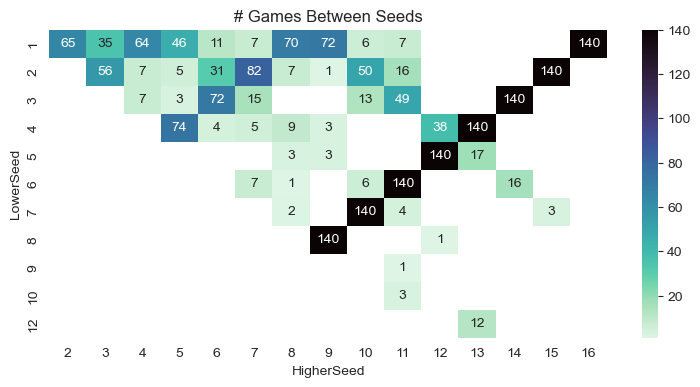

In [134]:
fig, ax = plt.subplots(figsize=(9,4)) 
sns.heatmap(data = df_htmp_count, cmap="mako_r", annot=True, square=False, fmt='g').set_title('# Games Between Seeds')

### Results
Here we are tabulating the number of games played between different seeds. <br>
For example, we can read this plot as there are a total of 3 games between 7 and 15 seeds. <br>
This plot gives us a sense of the sample size for each matchup. <br>
Do we really want to draw conclusions about a particular matchup when it has only occurred 3 times in the past?

## Upset Rate Heatmap

In the previous section, we saw how many times each seed-seed matchup occurred. Now we're interested in seeing the % of upsets in each matchup. An upset is defined as a weaker seed beating a stronger seed (i.e. a 15 seed beating a 7 seed, or a 2 seed beating a 1 seed).

To accomplish this, we first create two dataframes:
- A DF containing counts of upsets by seed matchup
- A DF containing total counts by seed matchup

In [135]:
df_upsets = df_t[df_t['Upset Val'] == 1].groupby(['LowerSeed', 'HigherSeed']).agg(counts=('W_Team', 'count')).reset_index()
df_total = df_t.groupby(['LowerSeed', 'HigherSeed']).agg(counts=('W_Team', 'count')).reset_index()

Then we join these two DFs together:

In [136]:
df_merged = df_upsets.merge(df_total, on=['LowerSeed', 'HigherSeed'], how='inner')

In [137]:
# Rename columns
df_merged = df_merged.rename(columns={'counts_x':'Upsets', 'counts_y':'Total'})

Now for each seed pairing (i.e. 1-2, 1-3, etc.) we have the total number of games and the total number of upsets. The p(upset) is simply Upsets/Total:

In [138]:
df_merged['UpsetRate'] = df_merged['Upsets']/df_merged['Total']

Before visualizing this data, we apply some filters:
- Only show matchups that occured at least 6 times
- Only show matchups where the LowerSeed (better seed) is <12
- Only show matchups where the UpsetRate < 1 (100%)

In [139]:
df_htmp = df_merged[df_merged['Total']>=6][['LowerSeed', 'HigherSeed', 'UpsetRate']]
df_htmp = df_htmp[(df_htmp['LowerSeed'] < 12)
                & (df_htmp['UpsetRate'] != 1)]
df_htmp = df_htmp.pivot(index='LowerSeed', columns='HigherSeed', values='UpsetRate')

Text(0.5, 1.0, '% of Games Resulting in Upset By Seed')

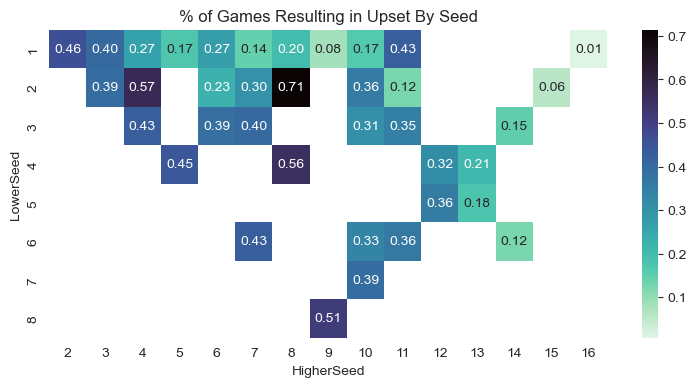

In [140]:
fig, ax = plt.subplots(figsize=(9,4)) 
sns.heatmap(data = df_htmp, cmap="mako_r", annot=True, fmt=".2f", square=False).set_title('% of Games Resulting in Upset By Seed')

#### Notes:

We are excluding rare matchups. For example, a 7-15 matchup is very rare and was excluded from the analysis. If such matchups were included, results may appear to be more significant then they actually are and would be misleading.

## Upsets by Round

In [141]:
df_round = df_t[df_t['Upset Val'] == 1].groupby(['LowerSeed', 'HigherSeed', 'Round']).agg(counts=('W_Team', 'count')).reset_index()
df_round_total = df_t.groupby(['LowerSeed', 'HigherSeed', 'Round']).agg(counts=('W_Team', 'count')).reset_index()

df_merged_rt = df_round.merge(df_round_total, on=['LowerSeed', 'HigherSeed', 'Round'], how='inner')
df_merged_rt = df_merged_rt.rename(columns={'counts_x':'Upsets', 'counts_y':'Total'})
df_merged_rt['UpsetRate'] = df_merged_rt['Upsets']/df_merged_rt['Total']

In [142]:
df_merged_rt['SeedMatchUp'] = df_merged_rt['LowerSeed'].astype(str) + '-' + df_merged_rt['HigherSeed'].astype(str)

In [143]:
df_merged_rt[df_merged_rt['Total']>0].pivot(index = 'SeedMatchUp', columns = 'Round', values = 'UpsetRate').head()

Round,Play-In,First Round,Second Round,Sweet 16,Elite Eight,Final Four,National Championship
SeedMatchUp,,,,,,,
1-10,NaN,NaN,NaN,NaN,0.20,0.00,NaN
1-11,NaN,NaN,NaN,NaN,0.43,NaN,NaN
1-12,NaN,NaN,NaN,0.00,NaN,NaN,NaN
1-13,NaN,NaN,NaN,0.00,NaN,NaN,NaN
1-16,NaN,0.01,NaN,NaN,NaN,NaN,NaN


In [144]:
df_round = df_t[df_t['Upset Val'] == 1].groupby(['Round']).agg(counts=('W_Team', 'count')).reset_index()
df_round_total = df_t.groupby(['Round']).agg(counts=('W_Team', 'count')).reset_index()

df_merged_rts = df_round.merge(df_round_total, on=['Round'], how='inner')
df_merged_rts = df_merged_rts.rename(columns={'counts_x':'Upsets', 'counts_y':'Total'})
df_merged_rts['UpsetRate'] = df_merged_rts['Upsets']/df_merged_rts['Total']

In [145]:
df_merged_rts

,Round,Upsets,Total,UpsetRate
0,Play-In,0,46,0.00
1,First Round,287,1120,0.26
2,Second Round,162,560,0.29
3,Sweet 16,80,280,0.29
4,Elite Eight,63,140,0.45
5,Final Four,18,70,0.26
6,National Championship,7,35,0.20


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Play-In'),
  Text(1, 0, 'First Round'),
  Text(2, 0, 'Second Round'),
  Text(3, 0, 'Sweet 16'),
  Text(4, 0, 'Elite Eight'),
  Text(5, 0, 'Final Four'),
  Text(6, 0, 'National Championship')])

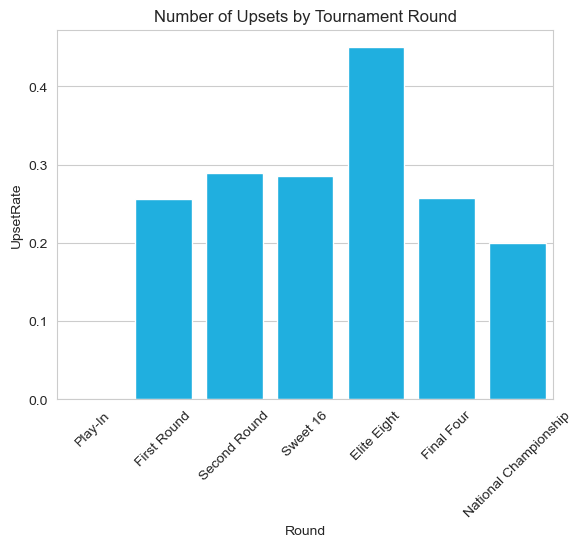

In [146]:
sns.barplot(data = df_merged_rts, 
            x='Round', 
            y='UpsetRate', 
            color='deepskyblue').set_title('Number of Upsets by Tournament Round')
plt.xticks(rotation=45)

## First Round Upsets

In [147]:
df_first_rnd_upsets = df_merged_rt[(df_merged_rt['Round'] == 'First Round') & (df_merged_rt['Upsets']>0)]
#df_first_rnd_upsets = df_first_rnd_upsets.pivot(index = 'LowerSeed', columns = 'HigherSeed', values = 'UpsetRate')

Text(0.5, 1.0, 'Upset Rate by Seed Pair: First Round')

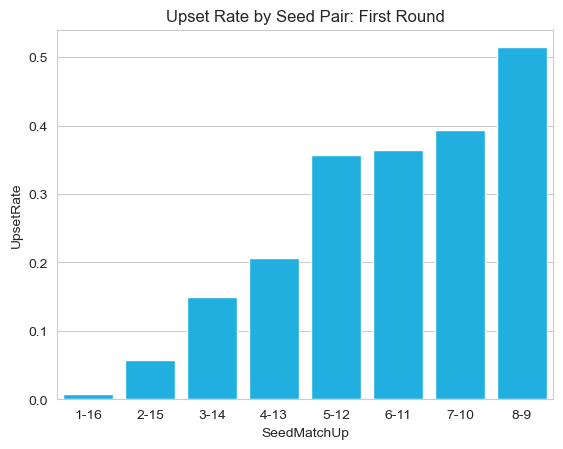

In [148]:
sns.barplot(data = df_first_rnd_upsets, 
            x='SeedMatchUp', 
            y='UpsetRate', 
            color='deepskyblue').set_title('Upset Rate by Seed Pair: First Round')

The most common upsets in the first round are:
- 8 seeds losing to 9 seeds
- 7 seeds losing to 10 seeds
- 6 seeds losing to 11 seeds
- 5 seeds losing to 12 seeds

Let's also check the sample size for each of these to see how often they actually occur, not just the rate of occurrance:

Text(0.5, 1.0, 'Upset Rate by Seed Pair: First Round')

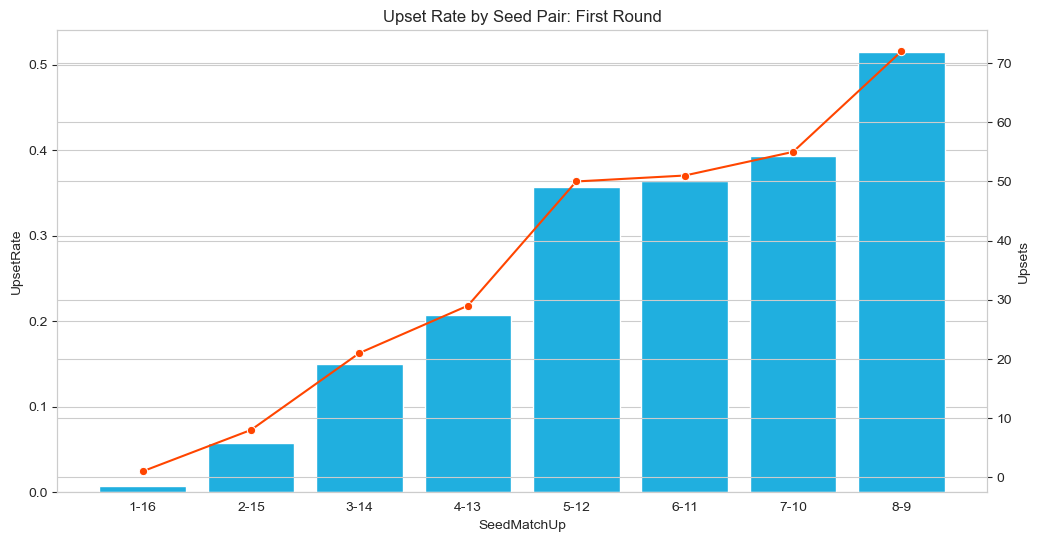

In [149]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1 = sns.barplot(data = df_first_rnd_upsets, 
            x='SeedMatchUp', 
            y='UpsetRate', 
            color='deepskyblue',
            ax = ax1)
ax2 = ax1.twinx()

sns.lineplot(data = df_first_rnd_upsets, 
            x='SeedMatchUp', 
            y='Upsets', 
            color='orangered', marker='o', sort = False, ax=ax2).set_title('Upset Rate by Seed Pair: First Round')
